In [2]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score
from scipy.stats import pearsonr

from util import plot, subject, stats
from util.path import Path
# from util.atlas import Atlas
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [3]:
%cd ..

/scratch/gpfs/zzada/fconv


In [4]:
modelname = "model-gpt2-2b_layer-24"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding_trialmot6"
cache = encmodel.split("_")[-1]

modelname, encmodel, cache

('model-gpt2-2b_layer-24', 'encoding_trialmot6', 'trialmot6')

In [5]:
cachedir = f"cache/figure3-mbc/{modelname}/{cache}/"
!mkdir -p $cachedir
cachedir

'cache/figure3-mbc/model-gpt2-2b_layer-24/trialmot6/'

In [5]:
def get_mbc(modelname:str):
    mbc_scores = defaultdict(list)

    # use subA's predictions on subB's actual neural data
    for subA in tqdm(SUBS_STRANGERS):
        # load subA preds
        encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
            comp_predA = f["cv_preds"][:, -1]
            prodmaskA = f["cv_prodmask"][...]

        # load subB preds
        subB = subject.get_partner(subA)
        encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            nuis_predsB = f["cv_preds"][:, :-2].sum(1)

        dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
        resB = dataB.reshape(5, 240, -1) - nuis_predsB

        compmaskA = ~prodmaskA

        for i in range(5):
            mbc_scores["prod"].append(correlation_score(prod_predA[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
            mbc_scores["comp"].append(correlation_score(comp_predA[i][compmaskA[i]], resB[i][compmaskA[i]]))

    sub_mbc_prod = np.stack(mbc_scores["prod"])
    sub_mbc_comp = np.stack(mbc_scores["comp"])
    
    return sub_mbc_prod, sub_mbc_comp

In [9]:
sub_mbc_prod, sub_mbc_comp = get_mbc(modelname)
sub_mbc_prod.shape

100%|██████████| 58/58 [13:41<00:00, 14.16s/it]


(290, 81924)

In [10]:
# save
with h5py.File(f"{cachedir}/mbc.hdf5", "w") as f:
    f.create_dataset(name="prod", data=sub_mbc_prod)
    f.create_dataset(name="comp", data=sub_mbc_comp)

In [6]:
# read
with h5py.File(f"{cachedir}/mbc.hdf5", "r") as f:
    sub_mbc_prod = f["prod"][...]
    sub_mbc_comp = f["comp"][...]

In [7]:
sub_mbc = (sub_mbc_prod + sub_mbc_comp) / 2
avg_mbc = (sub_mbc_prod.mean(0) + sub_mbc_comp.mean(0)) / 2
sub_mbc.shape, avg_mbc.shape

((290, 81924), (81924,))

In [8]:
sigmask = stats.ttest_1samp(sub_mbc, method='fdr_bh', alpha=0.05)
sigmask.sum()

32437

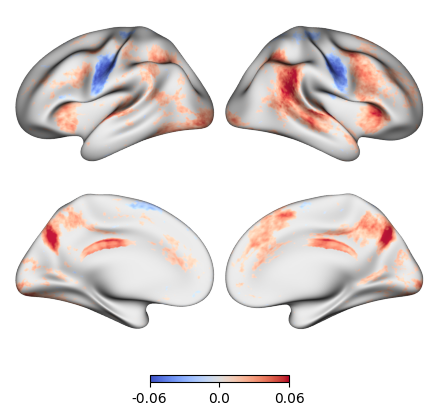

In [21]:
fig = plot.surface_plot(avg_mbc, threshold=~sigmask, cmap="coolwarm")
    # surf_lh_fn= "mats/suma-fsaverage6/lh.inflated.gii",
    # surf_rh_fn= "mats/suma-fsaverage6/rh.inflated.gii")

In [25]:
avg_mbc[~sigmask].min(), avg_mbc[~sigmask].max()

(-0.012693056, 0.013560791)

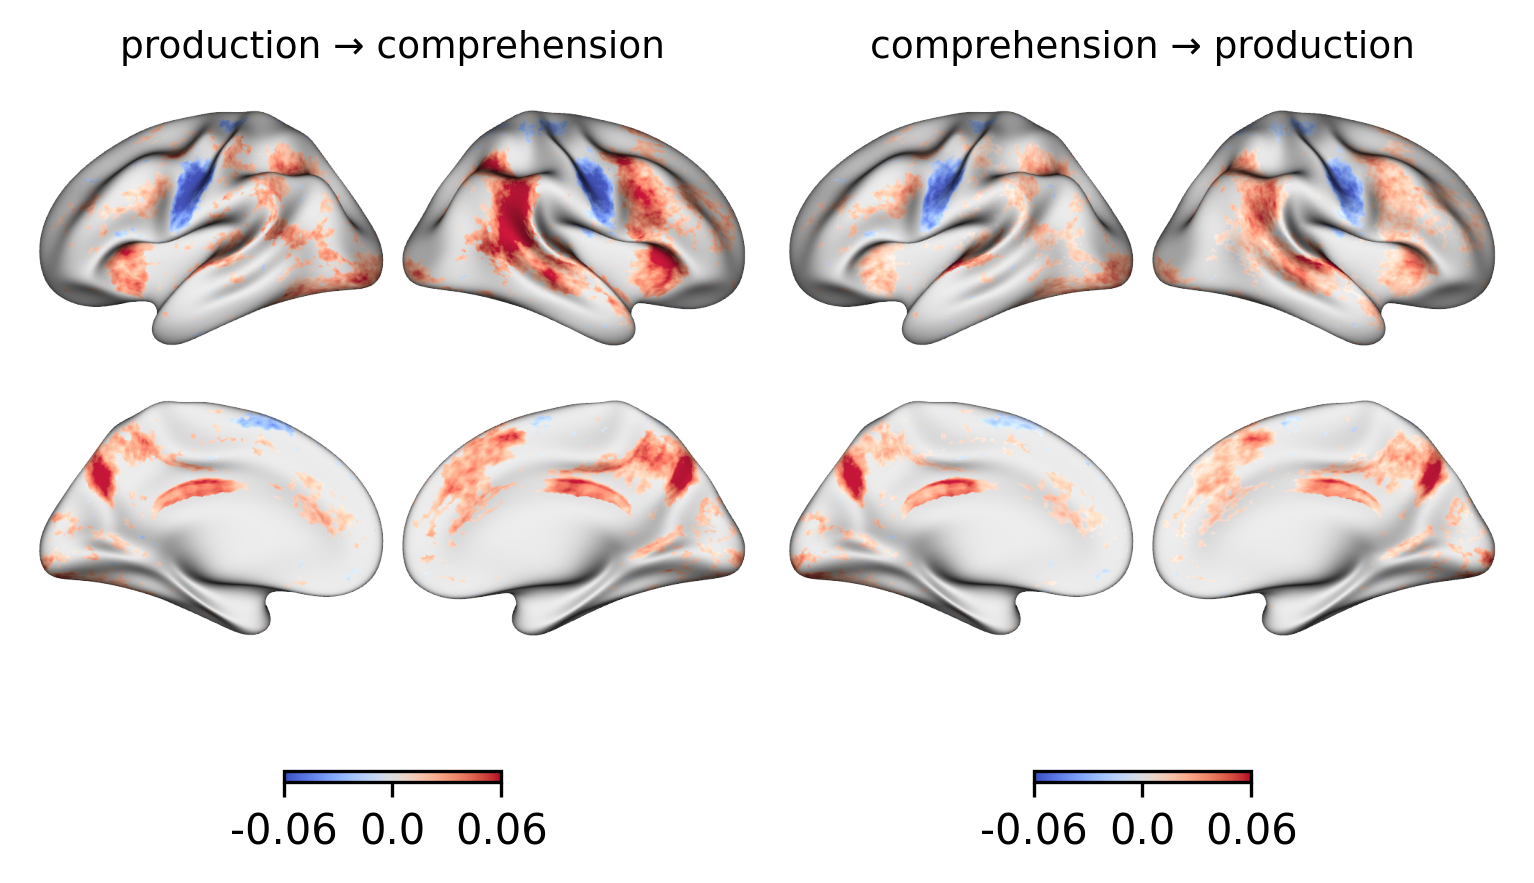

In [12]:
values1 = sub_mbc_prod.mean(0)
values2 = sub_mbc_comp.mean(0)
prod_cmap = comp_cmap = 'coolwarm'

fig, axes = plt.subplots(1, 2, figsize=(5, 5), layout='constrained', dpi=300)
plot.surface_plot(values1, threshold=~sigmask, fig=fig, ax=axes[0], vmax=0.06, cmap=prod_cmap, title='production → comprehension')
plot.surface_plot(values2, threshold=~sigmask, fig=fig, ax=axes[1], vmax=0.06, cmap=comp_cmap, title='comprehension → production')
fig.show()

# corr with encoding

In [14]:
respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = []
results_prod = []
results_comp = []
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        prod = f['cv_scores_prod'][:, -2] 
        comp = f['cv_scores_comp'][:, -1]
        results.append(np.mean(prod + comp, axis=0))
        results_prod.append(prod.mean(0))
        results_comp.append(comp.mean(0))

sub_enc_perf = np.stack(results)
avg_enc_perf = sub_enc_perf.mean(0)
avg_enc_perf.shape

100%|██████████| 58/58 [00:01<00:00, 41.67it/s]


(81924,)

In [8]:
r, p = pearsonr(avg_enc_perf, avg_mbc)
print(r, p)
print('abs', pearsonr(avg_enc_perf, np.abs(avg_mbc)))

0.47661226797664663 0.0
abs PearsonRResult(statistic=0.707720380975548, pvalue=0.0)


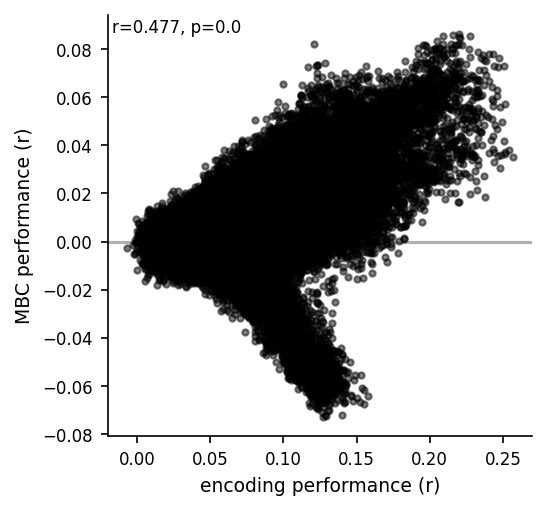

In [15]:
fig, ax = plt.subplots(figsize=(3.65, 3.65))
ax.scatter(avg_enc_perf, avg_mbc, marker='.', alpha=0.5, c='k')
ax.axhline(0, c="k", zorder=1, alpha=0.3)
ax.set_xlabel("encoding performance (r)")
ax.set_ylabel("MBC performance (r)")
ax.text(0.01, 0.99, f'r={r:0.3}, p={p}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left')
fig.show()

In [70]:
plot_params = dict(cmap="Grays", vmin=0, vmax=1, cbar=False, size=(800, 200), zoom=1.2, layout='row', mirror_views=True)

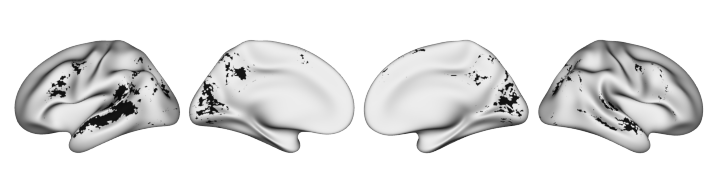

In [71]:
# within only
mask = (avg_enc_perf > .1) & (np.abs(avg_mbc) < .02)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, **plot_params);

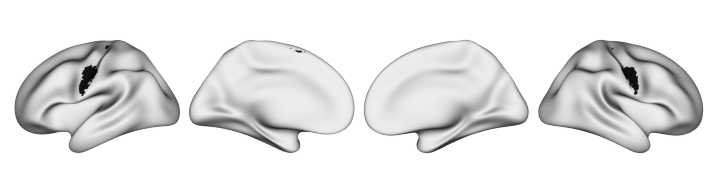

In [72]:
# negative
mask = (avg_enc_perf > .1) & (avg_mbc < -.02)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, **plot_params);

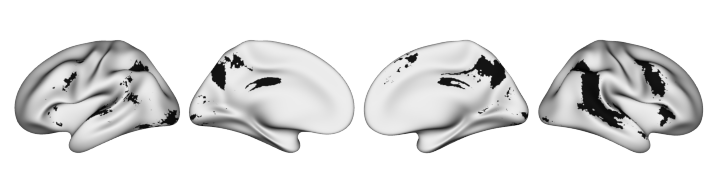

In [74]:
# positive
mask = (avg_enc_perf > .1) & (avg_mbc > .02)
values2 = np.ones_like(avg_mbc)
values2[~mask] = 0
plot.surface_plot(values2, **plot_params);

In [16]:
prod_within = np.stack(results_prod).mean(0)
comp_within = np.stack(results_comp).mean(0)

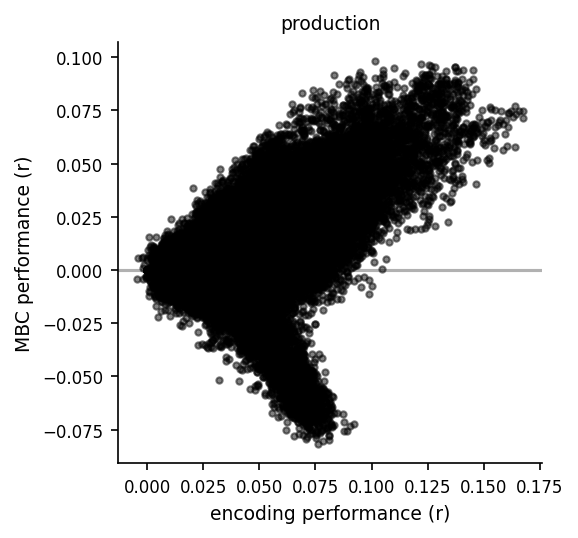

In [20]:
fig, ax = plt.subplots(figsize=(3.65, 3.65))
ax.scatter(prod_within, sub_mbc_prod.mean(0), marker='.', alpha=0.5, c='k')
# ax.scatter(comp_within, sub_mbc_comp.mean(0), marker='.', alpha=0.5, c='k')
ax.axhline(0, c="k", zorder=1, alpha=0.3)
ax.set_xlabel("encoding performance (r)")
ax.set_ylabel("MBC performance (r)")
ax.set_title('production')
# ax.text(0.01, 0.99, f'r={r:0.3}, p={p}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left')
fig.show()

# weight similarity

In [75]:
# sim between prod and comp
weight_sim_within = []
weight_sim_between = []

respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    desc='folds-2',
    ext=".hdf5",
)

for i, sub in enumerate(tqdm(SUBS_STRANGERS)):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        weights_prod = f["cv_weights_prod"][...].mean(0)
        weights_comp = f["cv_weights_comp"][...].mean(0)

    raw_corrs = correlation_score(weights_prod, weights_comp)
    weight_sim_within.append(raw_corrs)

    subB = subject.get_partner(sub)
    respath.update(sub=f"{subB:03d}")
    with h5py.File(respath, "r") as f:
        weights_compB = f["cv_weights_comp"][...].mean(0)
    raw_corrs = correlation_score(weights_prod, weights_compB)
    weight_sim_between.append(raw_corrs)

weight_sim_within = np.stack(weight_sim_within)
weight_sim_between = np.stack(weight_sim_between)
weight_sim_within.shape

100%|██████████| 58/58 [25:44<00:00, 26.63s/it]


(58, 81924)

In [76]:
# write
with h5py.File(f"{cachedir}/wbc.hdf5", "w") as f:
    f.create_dataset(name="within", data=weight_sim_within)
    f.create_dataset(name="between", data=weight_sim_between)

In [5]:
# read
with h5py.File(f"{cachedir}/wbc.hdf5", "r") as f:
    weight_sim_within = f["within"][...]
    weight_sim_between = f["between"][...]
weight_sim_between.shape

(116, 81924)

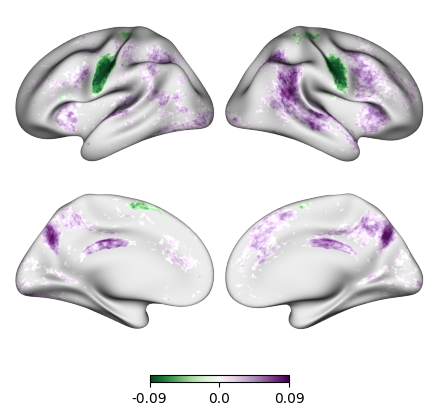

In [78]:
values = weight_sim_between.mean(0)
plot.surface_plot(values, threshold=~sigmask, cmap="PRGn_r");

# visualizing

In [65]:
subA = 104

In [114]:
# load subA preds
encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
with h5py.File(encpath, "r") as f:
    prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
    comp_predA = f["cv_preds"][:, -1]
    prodmaskA = f["cv_prodmask"][...]

# load subB preds
subB = subject.get_partner(subA)
encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
with h5py.File(encpath, "r") as f:
    nuis_predsB = f["cv_preds"][:, :-2].sum(1)#.reshape(1200, -1)

dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
# resB = dataB.reshape(5, 240, -1)
resB = dataB.reshape(5, 240, -1) - nuis_predsB
# resB = (dataB - zscore(nuis_predsB.reshape(1200, -1))).reshape(5, 240, -1)

compmaskA = ~prodmaskA

prod_predA.shape, comp_predA.shape, prodmaskA.shape, nuis_predsB.shape, resB.shape

((5, 240, 81924), (5, 240, 81924), (5, 240), (5, 240, 81924), (5, 240, 81924))

In [115]:
per_run = []
for i in range(5):
    per_run.append(correlation_score(prod_predA[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
per_run = np.stack(per_run).mean(0)

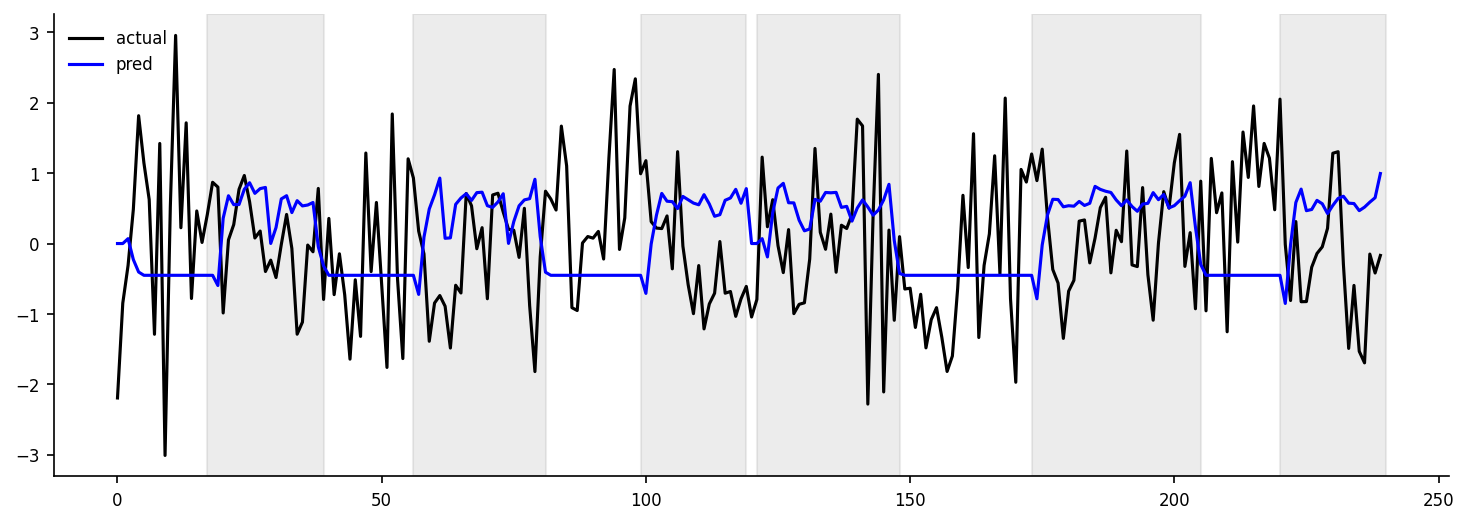

In [116]:
vox = 70117

fig, ax = plt.subplots(figsize=(12, 4))

switches = [0] + np.nonzero(np.diff(prodmaskA[0]))[0].tolist() + [240]
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i - 1], switches[i], color="gray", alpha=0.15, zorder=1)
# ax.plot(prodmaskA[0], c='k')

plt.plot(resB[0, :, vox], label='actual', c='k')
plt.plot(prod_predA[0, :, vox], label='pred', c='b')

ax.legend()
fig.show()